In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp


In [35]:
import pandas as pd

df = pd.read_csv("../data/processed/features_with_clusters.csv")
print(df.columns.tolist())


['user_id', 'timestamp', 'amount', 'time_since_last_txn', 'txn_count_1h', 'amount_zscore', 'device_change_rolling', 'geo_distance_rolling', 'risk_momentum', 'strategy_change', 'channel', 'location', 'is_fraud', 'cluster']


In [36]:
df = pd.read_csv("../data/processed/features_with_clusters.csv")

print(df.columns)  # sanity check

df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = df["timestamp"].dt.to_period("M")


Index(['user_id', 'timestamp', 'amount', 'time_since_last_txn', 'txn_count_1h',
       'amount_zscore', 'device_change_rolling', 'geo_distance_rolling',
       'risk_momentum', 'strategy_change', 'channel', 'location', 'is_fraud',
       'cluster'],
      dtype='str')


In [37]:
baseline_period = df["date"].min()
recent_period = df["date"].max()

baseline_df = df[df["date"] == baseline_period]
recent_df = df[df["date"] == recent_period]

baseline_period, recent_period


(Period('2024-01', 'M'), Period('2024-03', 'M'))

In [38]:
def drift_test(feature):
    base = baseline_df[feature].dropna()
    recent = recent_df[feature].dropna()
    
    stat, p_value = ks_2samp(base, recent)
    return stat, p_value


In [39]:
features_to_monitor = [
    "amount_zscore",
    "txn_count_1h",
    "risk_momentum",
    "geo_distance_rolling"
]

drift_results = []

for feature in features_to_monitor:
    stat, p = drift_test(feature)
    drift_results.append({
        "feature": feature,
        "ks_statistic": round(stat, 3),
        "p_value": round(p, 5),
        "drift_detected": p < 0.05
    })

drift_df = pd.DataFrame(drift_results)
drift_df


,feature,ks_statistic,p_value,drift_detected
0,amount_zscore,0.017,0.02379,True
1,txn_count_1h,0.002,1.00000,False
2,risk_momentum,0.033,0.00000,True
3,geo_distance_rolling,0.069,0.00000,True


In [40]:
baseline_clusters = baseline_df["cluster"].value_counts(normalize=True)
recent_clusters = recent_df["cluster"].value_counts(normalize=True)


cluster_drift = (
    pd.concat([baseline_clusters, recent_clusters], axis=1)
      .fillna(0)
)

cluster_drift.columns = ["baseline", "recent"]
cluster_drift["absolute_change"] = (
    cluster_drift["recent"] - cluster_drift["baseline"]
).abs()

cluster_drift


,baseline,recent,absolute_change
cluster,,,
0,0.961423,0.877363,0.084060
1,0.019549,0.017588,0.001961
-1,0.019028,0.103613,0.084585
2,0.000000,0.001436,0.001436


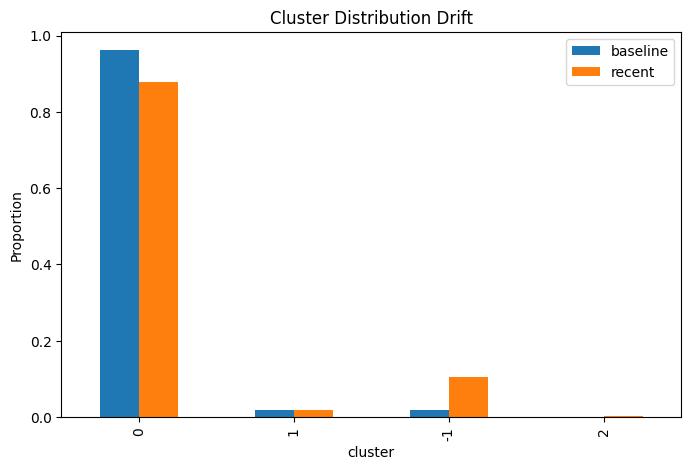

In [41]:
cluster_drift[["baseline", "recent"]].plot(
    kind="bar",
    figsize=(8,5)
)
plt.title("Cluster Distribution Drift")
plt.ylabel("Proportion")
plt.show()


In [42]:
fraud_rate_baseline = baseline_df["is_fraud"].mean()
fraud_rate_recent = recent_df["is_fraud"].mean()

fraud_rate_baseline, fraud_rate_recent


(np.float64(0.029149797570850202), np.float64(0.03092845178272314))

In [43]:
alerts = []

if drift_df["drift_detected"].any():
    alerts.append("⚠️ Feature distribution drift detected")

if (cluster_drift["absolute_change"] > 0.1).any():
    alerts.append("⚠️ Significant fraud pattern shift detected")

if fraud_rate_recent > fraud_rate_baseline:
    alerts.append("⚠️ Overall fraud risk increasing")

alerts


['⚠️ Feature distribution drift detected', '⚠️ Overall fraud risk increasing']